In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [3]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap1 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snap1s = uri.TimeSeries(snap1)
snap1s.read_iout_avail()
nout1 = snap1s.iout_avail['iout']
gal1s = pklload("./database/01_nh_ghmatch.pickle")
hal1s = uhmi.HaloMaker.load(snap1, galaxy=False, double_precision=dp)

mode = 'nh2'
iout = 797
repo, rurmode, dp = mode2repo(mode)
snap2 = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snap2s = uri.TimeSeries(snap2)
snap2s.read_iout_avail()
nout2 = snap2s.iout_avail['iout']
gal2s = pklload("./database/01_nh2_ghmatch.pickle")
hal2s = uhmi.HaloMaker.load(snap2, galaxy=False, double_precision=dp)

result1s = pklload(f"./database/03_MWA1s.pickle")
result2s = pklload(f"./database/03_MWA2s.pickle")
pair1s = pklload(f"./database/06_nh_subhalo_pairs.pickle")
pair2s = pklload(f"./database/06_nh2_subhalo_pairs.pickle")

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)
[Output 00797] Age (Gyr) : 11.623 / 13.741, z = 0.17158 (a = 0.8536)


In [4]:
pair1s.keys()

dict_keys([1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 17, 19, 20, 21, 23, 24, 25, 26, 29, 35, 36, 37, 40, 41, 46, 47, 52, 54, 60, 63, 64, 65, 66, 68, 75, 84, 91, 92, 104, 107, 108, 121, 129, 133, 136, 148, 165, 168, 207, 212, 937, 1252, 1545, 1920])

In [5]:
pair1s[1]

{'pair': [(20795, 178),
  (20781, 220),
  (20811, 226),
  (20731, 290),
  (20825, 510),
  (20716, 575),
  (20816, 606),
  (20820, 1115),
  (20821, 1117)],
 'sat_age': array([ 4.54862208,  4.03858622,  4.81793426,  9.87451348,  6.46166766,
         9.50671054,  7.6810346 ,  8.84943744, 10.8476686 ,  7.55158833,
         5.56719733,  1.52511058,  2.57175438,  0.42545732,  1.03522772,
         0.37217684,  1.76473498,  1.35067567,  1.31040467,  1.17891187,
         1.52748789,  0.98226534,  0.94349869,  1.69719298,  2.2666961 ,
         1.27948159,  4.44880774,  1.65535544,  2.07914258,  0.96549263,
         1.23535881,  0.85425294,  1.1507972 ,  1.15520623,  0.90421921,
         1.0510595 ,  0.91976764,  1.05882079,  1.62902125,  0.92657459,
         0.96902727,  1.2103872 ,  1.06573958,  1.10626836,  0.93164015,
         0.92015123,  1.31935443,  0.84181558,  1.49986868,  1.52881116,
         1.79755209,  1.06414584,  1.49874694,  1.83665653,  1.41844727,
         1.27642935,  0.4351252

In [6]:
star = None; dm = None; cell = None
rband = None

Computing particle map of 7810230 particles... 
Done (0.541s).


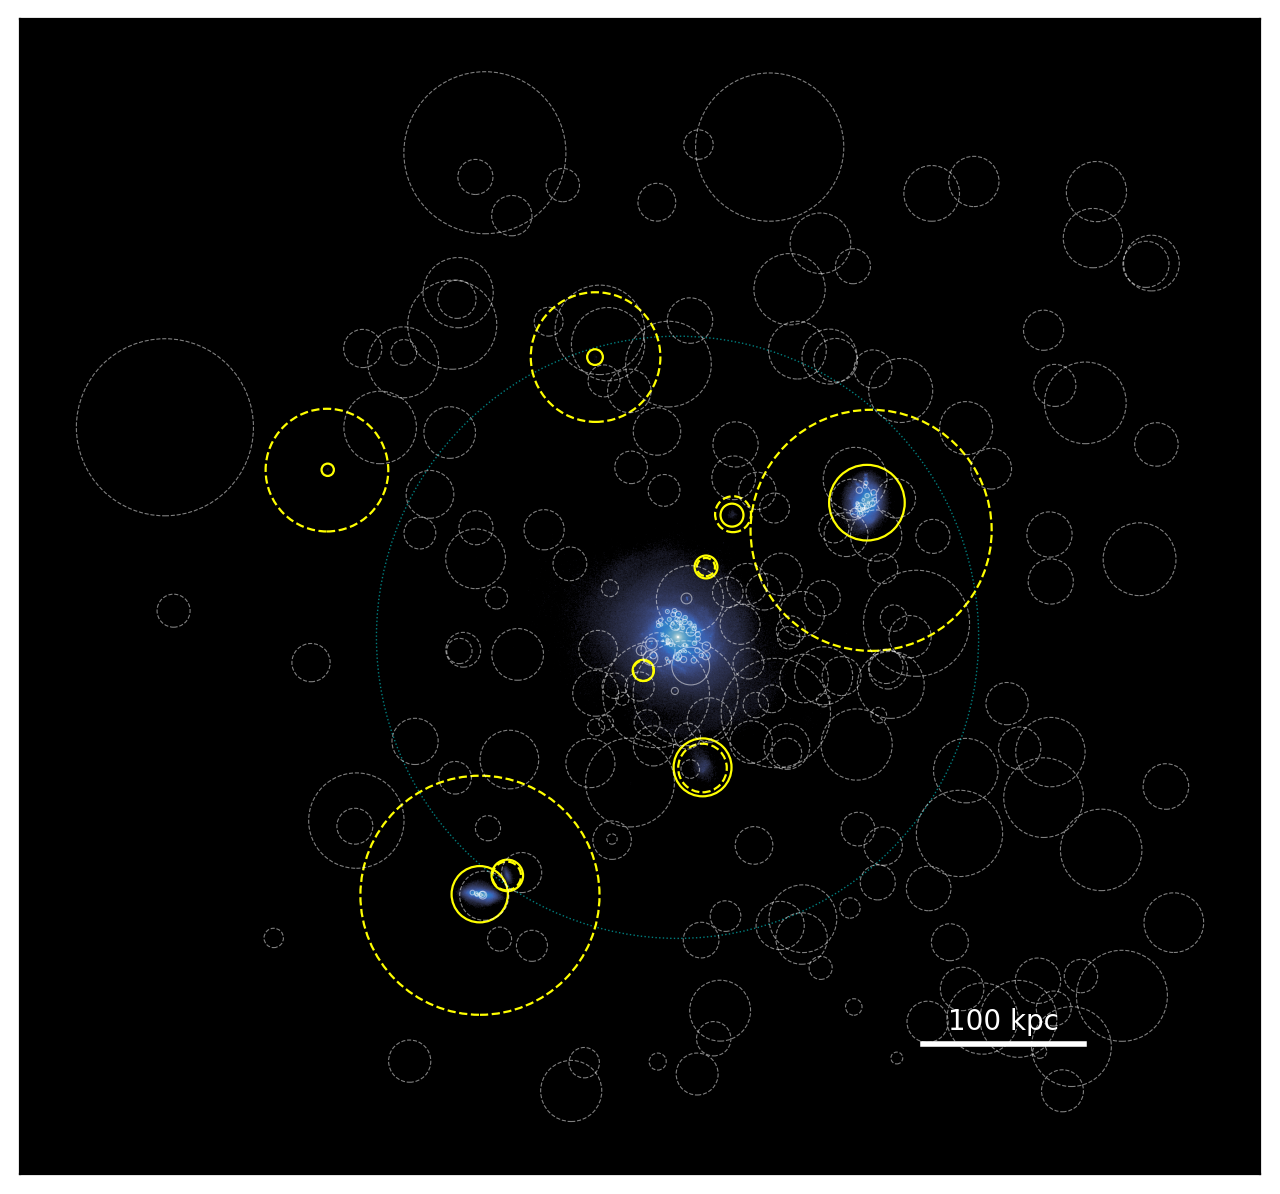

In [7]:
for MWA1 in result1s:
    dic = pair1s[MWA1['id']]
    pairs = dic['pair']
    all_sats = dic['all_sat']
    all_subs = dic['all_sub']

    snap1.set_box_halo(MWA1, 1.5, radius_name='r200_code')
    if(star is None): star = uri.Particle( pklload(f"./database/parts/nh_star_{MWA1['id']:04}.pickle"), snap1)
    if(dm is None): dm = uri.Particle( pklload(f"./database/parts/nh_dm_{MWA1['id']:04}.pickle"), snap1)
    if(cell is None): cell = uri.Cell( pklload(f"./database/parts/nh_cell_{MWA1['id']:04}.pickle"), snap1 )
    if(rband is None): rband = measure_luminosity(star, 'SDSS_r')

    fig, ax = fancy_axis(figsize=(8, 8), dpi=200)
    
    painter.draw_partmap(star, box=snap1.box, ax=ax, cmap=cmr.arctic, qscale=5, weights=rband, shape=1080)

    cir = circle(MWA1, rname='r200_code', ls=':', alpha=0.5, color='cyan')
    ax.add_patch(cir)


    sats = gal1s[[pair[1]-1 for pair in pairs]]
    subs = hal1s[[pair[0]-1 for pair in pairs]]
    for sat,sub in zip(sats, subs):
        cir = circle(sat, rname='r', color='yellow', lw=0.8)
        ax.add_patch(cir)
        cir = circle(sub, rname='rvir', ls='--', color='yellow', lw=0.8)
        ax.add_patch(cir)

    for all_sat in all_sats:
        if(all_sat in sats['id']): continue
        sat = gal1s[all_sat-1]
        cir = circle(sat, rname='r', lw=0.4, alpha=0.5)
        ax.add_patch(cir)
    for all_sub in all_subs:
        if(all_sub in subs['id']): continue
        sub = hal1s[all_sub-1]
        cir = circle(sub, rname='rvir', ls='--', lw=0.4, alpha=0.5)
        ax.add_patch(cir)
    add_scalebar(ax, snap1.unit_l)

    plt.show()
    plt.close()
    break

100%|██████████| 54/54 [00:01<00:00, 28.13it/s]


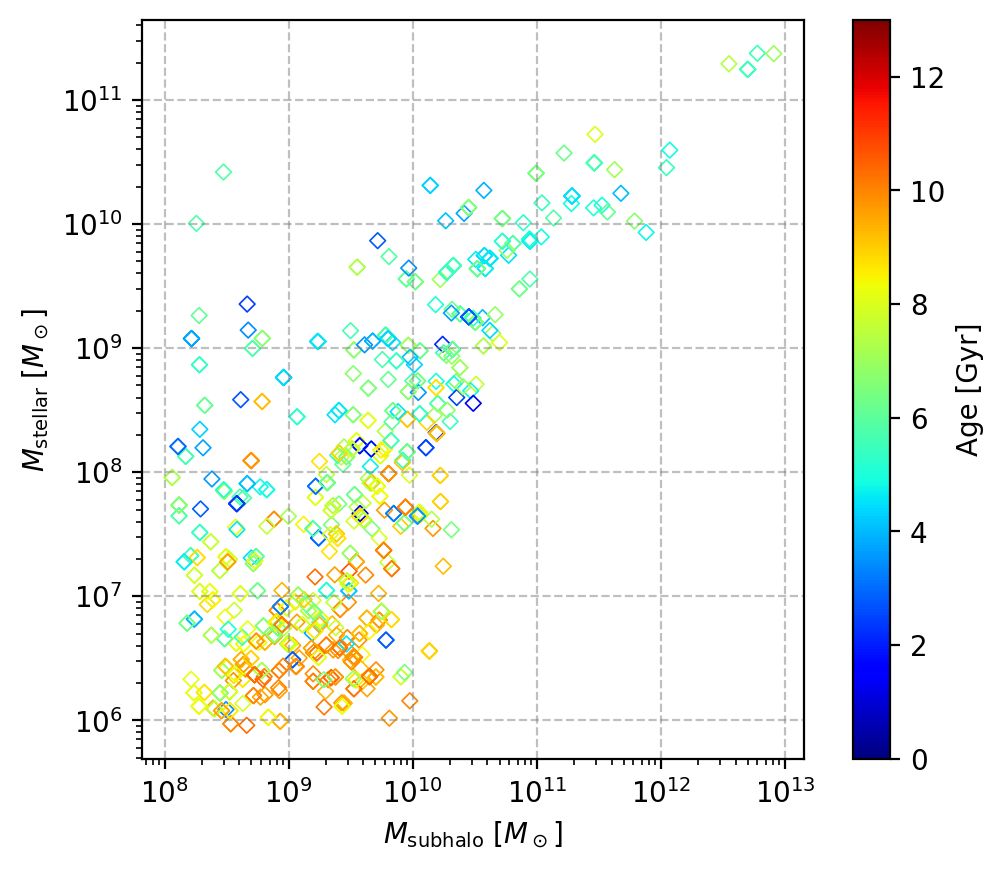

In [8]:
from matplotlib.colors import Normalize
cmap = plt.cm.jet
norm = Normalize(vmin=0, vmax=13)


fig, ax = plt.subplots(dpi=200)
# ax.set_facecolor('k')
ax.grid(True, ls='--', color='gray', alpha=0.5)
for key, pair1 in tqdm( pair1s.items() ):
    pair = pair1['pair']
    for p in pair:
        sub = hal1s[p[0]-1]
        sat = gal1s[p[1]-1]
        where = np.where(pair1['all_sat'] == p[1])[0][0]
        age = pair1['sat_age'][where]

        ax.scatter(sub['mvir'], sat['m'], edgecolor=cmap(norm(age)), marker='D', facecolor='none', lw=0.6, s=16)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r'$M_{\rm subhalo}$ [$M_\odot$]')
ax.set_ylabel(r'$M_{\rm stellar}$ [$M_\odot$]')
ax.set_aspect(1)

# add colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Age [Gyr]')
plt.savefig(f"./database/photo/07_nh_pairs_mass.png", bbox_inches="tight", dpi=400, facecolor='white')
plt.show()

# Tracking

In [15]:
hostkeys = list( pair1s.keys() )
pair1 = pair1s[hostkeys[0]]['pair']

for pair in pair1:
    print(pair)
    gal = gal1s[pair[1]-1]
    stars = uhmi.HaloMaker.read_member_part(snap1, pair[1], galaxy=True)
    print(len(stars))
    dist = distance(gal, stars)
    dist -= np.min(dist)
    dist /= np.max(dist)
    vels = distance(gal, stars, vel=True)
    vels -= np.min(vels)
    vels /= np.max(vels)
    scores = dist + vels
    top100 = np.argsort(scores)[:100]
    stars = stars[top100]

    hal = hal1s[pair[0]-1]
    dms = uhmi.HaloMaker.read_member_part(snap1, pair[0], galaxy=False)
    print(len(dms))
    dist = distance(hal, dms)
    dist -= np.min(dist)
    dist /= np.max(dist)
    vels = distance(hal, dms, vel=True)
    vels -= np.min(vels)
    vels /= np.max(vels)
    scores = dist + vels
    top100 = np.argsort(scores)[:100]
    dms = dms[top100]

    

    break

(20795, 178)
647680
45359


In [17]:
uri.timer.verbose=0
cmap = plt.cm.rainbow
norm = Normalize(vmin=lastgyr-9, vmax=lastgyr)

fig, ax = plt.subplots(dpi=200)
ax.set_facecolor('k')
ini=True
i = 0
for cout in tqdm(couts):
    snap = snap1s.get_snap(cout)
    snap.clear()
    gyr = lastgyr - i
    print(cout, gyr)
    if(ini):
        ini=False
        target_stars = stars
        target_dms = dms

        ax.scatter(target_stars['x'], target_stars['y'], facecolor=cmap(norm(gyr)), marker='.', s=4, edgecolor='none')
        ax.scatter(target_dms['x'], target_dms['y'], facecolor='none',edgecolor=cmap(norm(gyr)), marker='D', s=4, lw=0.3, alpha=0.5)
    else:
        snap.set_box([cxs,cys,czs], dx)
        print("-----star-----")
        snap.get_part(pname='star', target_fields=['x','y','z','epoch','id','cpu'])
        count = 0
        stars = stars[stars['age', 'Gyr'] > lastgyr-gyr+0.3]
        ind = isin(np.abs(snap.part['id']), stars['id'])
        while(np.sum(ind) < len(stars)):
            print(len(stars), np.sum(ind))
            if(True in ind):
                cxs = np.mean(snap.part['x'][ind])
                cys = np.mean(snap.part['y'][ind])
                czs = np.mean(snap.part['z'][ind])
            count+=1
            dx *= 2
            snap.set_box([cxs,cys,czs], dx)
            snap.get_part(pname='star', target_fields=['x','y','z','epoch','id','cpu'])
            ind = isin(np.abs(snap.part['id']), stars['id'])
            if(count > 7): break
        if(True in ind):
            target_stars = snap.part[ind]
            ax.scatter(target_stars['x'], target_stars['y'], facecolor=cmap(norm(gyr)), marker='.', s=4, edgecolor='none')
        snap.clear()
        print("-----dm-----")
        snap.set_box([cxd,cyd,czd], dx)
        snap.get_part(pname='dm', target_fields=['x','y','z','epoch','id','cpu'])
        ind = isin(np.abs(snap.part['id']), dms['id'])
        count = 0
        while(np.sum(ind) < len(dms)):
            print(len(dms), np.sum(ind))
            if(True in ind):
                cxd = np.mean(snap.part['x'][ind])
                cyd = np.mean(snap.part['y'][ind])
                czd = np.mean(snap.part['z'][ind])
            dx *= 2
            snap.set_box([cxd,cyd,czd], dx)
            snap.get_part(pname='dm', target_fields=['x','y','z','epoch','id','cpu'])
            ind = isin(np.abs(snap.part['id']), dms['id'])
            if(count > 7): break
        if(True in ind):
            target_dms = snap.part[ind]
            ax.scatter(target_dms['x'], target_dms['y'], facecolor='none',edgecolor=cmap(norm(gyr)), marker='D', s=4, lw=0.3, alpha=0.5)
        snap.clear()

    cxs, cys, czs = np.mean(target_stars['x']), np.mean(target_stars['y']), np.mean(target_stars['z'])
    # cvxs, cvys, cvzs = np.mean(target_stars['vx']), np.mean(target_stars['vy']), np.mean(target_stars['vz'])
    # cxs -= cvxs * 3.154E16/snap.unit_t
    # cys -= cvys * 3.154E16/snap.unit_t
    # czs -= cvzs * 3.154E16/snap.unit_t
    cxd, cyd, czd = np.mean(target_dms['x']), np.mean(target_dms['y']), np.mean(target_dms['z'])
    # cvxd, cvyd, cvzd = np.mean(target_dms['vx']), np.mean(target_dms['vy']), np.mean(target_dms['vz'])
    # cxd -= cvxd * 3.154E16/snap.unit_t
    # cyd -= cvyd * 3.154E16/snap.unit_t
    # czd -= cvzd * 3.154E16/snap.unit_t
    dxs, dys, dzs = np.max(target_stars['x'])-np.min(target_stars['x']), np.max(target_stars['y'])-np.min(target_stars['y']), np.max(target_stars['z'])-np.min(target_stars['z'])
    dxd, dyd, dzd = np.max(target_dms['x'])-np.min(target_dms['x']), np.max(target_dms['y'])-np.min(target_dms['y']), np.max(target_dms['z'])-np.min(target_dms['z'])
    dx = np.max([dxs, dxd, dyd, dys, dzd, dzs])
    i+=1
uri.timer.verbose=1

  0%|          | 0/4 [00:00<?, ?it/s]

1026 11.62402615
758 10.62402615
-----star-----
100 0
100 0
100 0
100 0
100 0
100 0
100 94
100 94
-----dm-----


 50%|█████     | 2/4 [03:46<03:46, 113.16s/it]

518 9.62402615
-----star-----
95 0
95 0
95 0
95 73
95 73
95 73


In [18]:
stars['age','Gyr']

array([ 9.19652224,  9.74099284,  6.1839404 ,  3.80936939, 10.33421419,
        8.3429898 ,  8.84652979,  8.4254305 ,  5.76833357,  8.62465955,
        8.86422307,  3.22534445,  8.87009144,  7.70788224,  8.29611869,
        2.63099997,  8.06278613,  6.48137618,  8.06359407,  8.43277535,
        9.4634657 ,  8.04952515,  8.00927131,  5.28929558,  7.51285527,
        7.14263611,  7.69815353,  4.18347834, 10.08003219,  8.28155307,
        4.99081226,  5.81322975,  7.42135749,  8.88232547,  4.19012442,
        7.49513733,  3.9421701 ,  7.30077842,  8.2894246 ,  3.87535305,
        7.72683856,  3.63050705,  7.74067134,  1.37705099,  3.8578476 ,
        8.87065361,  5.83551134,  2.03375188,  8.29733325,  7.84984998,
        6.47465678,  1.78744519,  8.29943161,  7.31615976,  3.68918219,
        1.6802448 ,  6.07878056,  9.19296134,  6.03222765,  4.82567442,
        8.18588428,  7.10081737,  8.47795781,  4.6308239 ,  1.70527866,
        7.88329085,  4.90875629,  7.73615905,  9.17300346,  2.42

In [20]:
lastgyr-gyr+0.3

0.3